In [1]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
import parcels
parcels.__version__ # para saber la versión del paquete parcels que estamos usando

'3.1.0'

In [3]:
filedir = '/home/jovyan/shared/ohwe24_hackaton/proy2/'

In [29]:
!ls /home/jovyan/shared/ohwe24_hackaton/proy2/

cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980101.nc
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980102.nc
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980103.nc
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980104.nc
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980105.nc
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980106.nc
mercatorbiomer4v2r1_global_mean_bio_20220101.nc
mercatorbiomer4v2r1_global_mean_bio_20220102.nc
mercatorbiomer4v2r1_global_mean_bio_20220103.nc
mercatorbiomer4v2r1_global_mean_bio_20240101.nc
mercatorbiomer4v2r1_global_mean_bio_20240102.nc
mercatorbiomer4v2r1_global_mean_bio_20240103.nc
mercatorbiomer4v2r1_global_mean_bio_20240104.nc
mercatorbiomer4v2r1_global_mean_bio_20240105.nc
mercatorbiomer4v2r1_global_mean_bio_20240106.nc
mercatorbiomer4v2r1_global_mean_bio_20240107.nc
mercatorbiomer4v2r1_global_mean_bio_20240108.nc
mercatorbiomer4v2r1_global_mean_bio_20240109.nc
mercatorbiomer4v2r1_global_mean_bio_20240110.nc
mercatorbiomer4v2r1_gl

In [54]:
ds_m = xr.open_dataset(filedir + 'cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_19980105.nc')

In [55]:
!pwd

/home/jovyan/ohwe24-proy2-plasticos


In [56]:
ds_m

<xarray.Dataset> Size: 846MB
Dimensions:              (latitude: 2040, longitude: 4320, time: 1, depth: 3)
Coordinates:
  * latitude             (latitude) float32 8kB -80.0 -79.92 ... 89.83 89.92
  * longitude            (longitude) float32 17kB -180.0 -179.9 ... 179.8 179.9
  * time                 (time) datetime64[ns] 8B 1998-01-05T12:00:00
  * depth                (depth) int32 12B 1 2 3
Data variables:
    T                    (time, depth, latitude, longitude) float64 212MB ...
    U                    (time, depth, latitude, longitude) float64 212MB ...
    V                    (time, depth, latitude, longitude) float64 212MB ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 212MB ...
Attributes:
    title:                      Physical forcings of global ocean low and mid...
    source:                     SEAPODYM-LMTL 3.0.0
    references:                 http://www.cls.fr; http://www.seapodym.eu
    institution:                CLS
    Conventions:                CF-1.7
    source_physical_variables:  GLOBAL_REANALYSIS_PHY_001_030 CMEMS product
    spatial_resolution:         0.083x0.083
    temporal_resolution:        1 day
    domain:                     global
    date_field:                 19980105
    history:                    Created on 2022-09-28

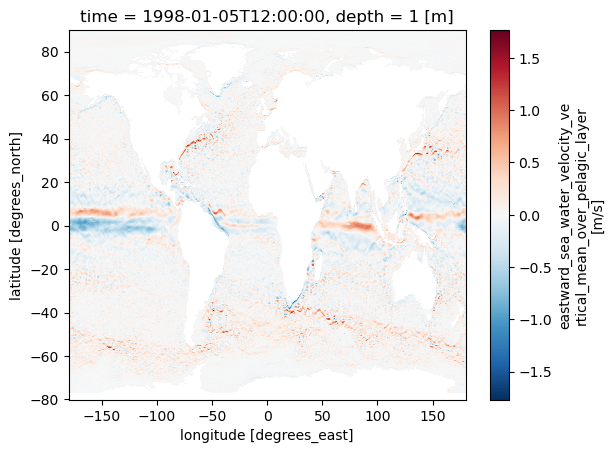

In [74]:
ds_m.U[0,0,:,:].plot()

In [75]:
lon_min = -76
lon_max = -72
lat_min = -44
lat_max = -41

In [76]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


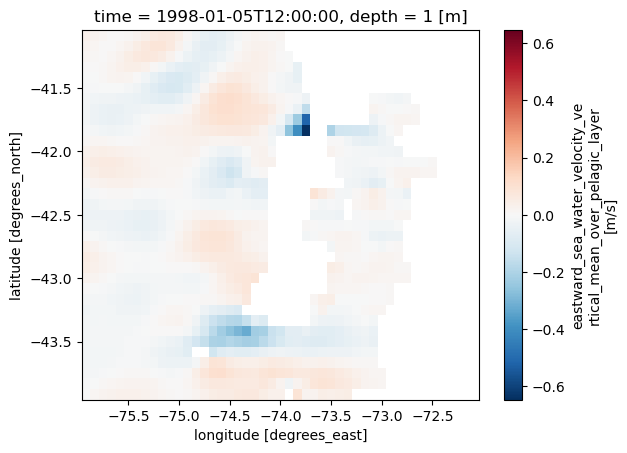

In [77]:
ds_m_sub.U[0,0,:,:].plot()

In [122]:
import os  # Importamos el módulo os para trabajar con rutas
import glob  # Importamos glob para buscar archivos
from parcels import FieldSet  # Importamos FieldSet para trabajar con Parcels


# Directorio donde están los archivos
filedir =  '/home/jovyan/shared/ohwe24_hackaton/proy2/'


# Verificar si el directorio existe
if not os.path.exists(filedir):
    raise FileNotFoundError(f"El directorio '{filedir}' no existe o no es accesible")

# Usamos glob para obtener la lista de archivos que coinciden con el patrón
u_files = sorted(glob.glob(filedir + "cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_1998010[1-6].nc"))
v_files = sorted(glob.glob(filedir + "cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_1998010[1-6].nc"))

# Confirmar que los archivos se encontraron
if not u_files:
    raise FileNotFoundError(f"No se encontraron archivos para U con el patrón: {filedir}cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_1998010[1-6].nc")
if not v_files:
    raise FileNotFoundError(f"No se encontraron archivos para V con el patrón: {filedir}cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_1998010[1-6].nc")

# Crear el diccionario de ficheros para U y V
ficheros = {'U': u_files, 'V': v_files}

# Configurar las variables y dimensiones
variables = {'U': 'U', 'V': 'V'}  # Ajusta según los nombres de las variables en los archivos .nc
dimensiones = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}  # Ajusta según los archivos .nc

# Cargar el FieldSet
try:
    fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, allow_time_extrapolation=True)
    print("FieldSet cargado con éxito")
except Exception as e:
    raise RuntimeError(f"Error al cargar el FieldSet: {e}")


FieldSet cargado con éxito


In [144]:
import numpy as np
from parcels import ParticleSet, JITParticle

# Rango de longitudes y latitudes para el Mar Interior de Chiloé
lon1D = fieldset.U.lon[np.arange(320, 325, 1)]  # Longitudes aproximadas para el Mar Interior de Chiloé
lat1D = fieldset.U.lat[np.arange(380, 385, 1)]  # Latitudes aproximadas para la zona de interés

# Crear una malla de coordenadas para las partículas
lons, lats = np.meshgrid(lon1D, lat1D)

# Crear el conjunto de partículas con las coordenadas seleccionadas
pset_B = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)

# Verificar si la malla de partículas se ha creado correctamente
print(f'Número de partículas en el conjunto: {len(pset_B)}')


Número de partículas en el conjunto: 25


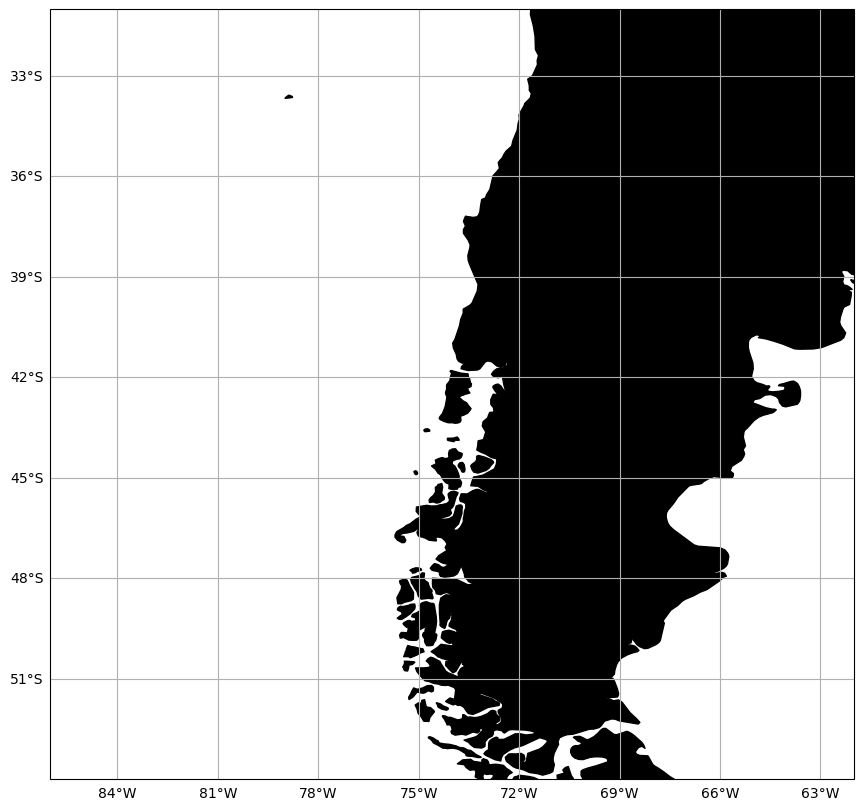

In [145]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_B.lon, pset_B.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-10., lon_max+10.])
ax1.set_ylim([lat_min-10., lat_max+10.])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER#esta celda con la anterior se define cuantas y donde se lanzan las particulas


In [125]:
runtime_days = 6#dias que corre

In [126]:
fichero_salida_B = "lag_simu_pset_B_test01" # fichero guardado en formato .zarr que es equivalente a netcdf (.nc)

In [127]:
output_file = pset_B.ParticleFile(name=fichero_salida_B, outputdt=timedelta(hours=24))
pset_B.execute(pset_B.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_B_test01.zarr.
100%|██████████| 518400.0/518400.0 [00:06<00:00, 77787.75it/s]


In [128]:
!ls -trl # para ver los nuevos ficheros en nuestro directorio

6245.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


total 2084
-rw-r--r-- 1 jovyan jovyan   1079 Nov 25 17:50 LICENSE
drwxr-xr-x 8 jovyan jovyan   4096 Nov 26 16:56 lag_simu_pset_A_test01.zarr
-rw-r--r-- 1 jovyan jovyan   1724 Nov 26 17:15 Untitled.ipynb
-rw-r--r-- 1 jovyan jovyan 568289 Nov 26 18:29 proyecto2.ipynb
-rw-r--r-- 1 jovyan jovyan    716 Nov 27 18:34 README.md
-rw-r--r-- 1 jovyan jovyan 300044 Nov 27 18:34 test02-.ipynb
-rw-r--r-- 1 jovyan jovyan 612703 Nov 27 18:36 test01.ipynb
-rw-r--r-- 1 jovyan jovyan 623822 Nov 27 19:38 Prueba.ipynb
drwxr-xr-x 8 jovyan jovyan   4096 Nov 27 19:39 lag_simu_pset_B_test01.zarr


In [129]:
ds = xr.open_dataset("lag_simu_pset_B_test01.zarr")

/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [130]:
ds

<xarray.Dataset> Size: 3kB
Dimensions:     (trajectory: 25, obs: 6)
Coordinates:
  * obs         (obs) int32 24B 0 1 2 3 4 5
  * trajectory  (trajectory) int64 200B 200 201 202 203 204 ... 221 222 223 224
Data variables:
    lat         (trajectory, obs) float32 600B ...
    lon         (trajectory, obs) float32 600B ...
    time        (trajectory, obs) datetime64[ns] 1kB ...
    z           (trajectory, obs) float32 600B ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.0

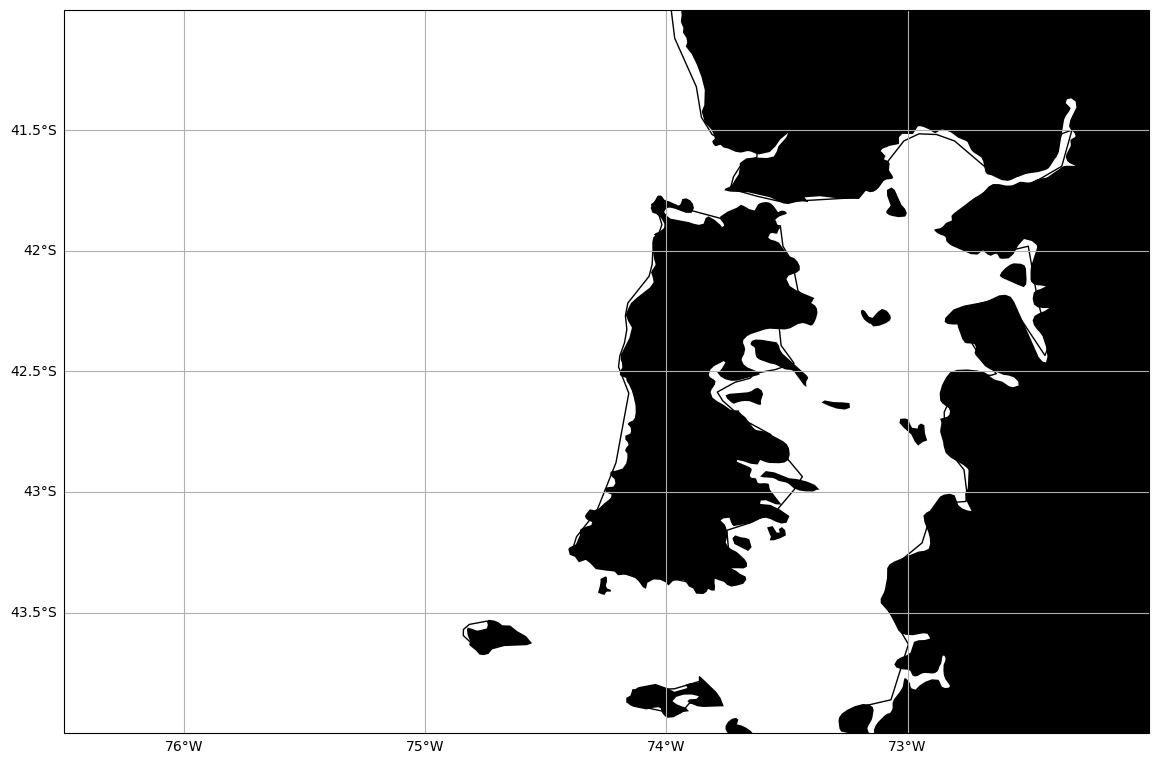

In [131]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-0.5, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


AttributeError: Rectangle.set() got an unexpected keyword argument 'vmin'

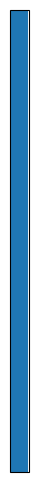

In [132]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.U[0,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min-0.5, -77.6])
ax1.set_ylim([lat_min, 9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
